IMPORTING RELEVANT LIBRARIES

In [1]:
#Import libraries
import pandas as pd #For data manipulation and analysis
import os #For file and directory manipulation
import numpy as np #For numerical operations
import matplotlib.pyplot as plt #For data visualization
import seaborn as sns #For statistical data visualization
import random #For random number generation
import xgboost
import matplotlib.pyplot as plt
import shap


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder #For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, adjusted_rand_score,normalized_mutual_info_score,homogeneity_completeness_v_measure
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from IPython.display import display, HTML


CHECKING XGBOOST MODEL

In [2]:
print("XGBoost version:", xgboost.__version__)

XGBoost version: 3.0.2


LOADING DATA

In [3]:
# Load the loan data from a CSV file into a DataFrame
filepath = 'loan_data.csv' 

# Read the CSV file into a pandas DataFrame
df_Train = pd.read_csv(filepath, sep=',')

# Display concise summary of the DataFrame, including column types and non-null counts
df_Train.info()

# Display the first 10 rows of the DataFrame for a quick data preview
display(df_Train.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


DATA PREPROCESSING

In [4]:
# Check for Duplicates and Drop them

before = df_Train.shape[0]  # Store the number of rows before removing duplicates
df_Train = df_Train.drop_duplicates()  # Remove duplicate rows from the DataFrame
after = df_Train.shape[0]  # Store the number of rows after removing duplicates

print(f"Duplicates dropped: {before - after}")  # Print the number of duplicates removed
print(f"New shape: {df_Train.shape}")  # Print the new shape of the DataFrame


Duplicates dropped: 0
New shape: (45000, 14)


In [5]:
# Encode categorical variables

label_cols = df_Train.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in label_cols:
    df_Train[col] = le.fit_transform(df_Train[col].astype(str))


In [6]:
# View the updated Datatype info
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  int64  
 2   person_education                45000 non-null  int64  
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  int64  
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  int64  
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [7]:
#Renaming columns for better readability
df_Train.rename(columns={
    'person_age': 'Age',
    'person_gender': 'Gender',
    'person_education': 'Education_Level',
    'person_income': 'Annual_Income',
    'person_emp_exp': 'Employment_Years',
    'person_home_ownership': 'Home_Ownership',
    'loan_amnt': 'Loan_Amount',
    'loan_intent': 'Loan_Purpose',
    'loan_int_rate': 'Loan_Interest_Rate',
    'loan_percent_income': 'Loan_Percentage_Income',
    'cb_person_cred_hist_length': 'Credit_History_Length',
    'credit_score': 'Credit_Score',
    'previous_loan_defaults_on_file': 'Previous_Loan_Defaults',
    'loan_status': 'Loan_Status'
}, inplace=True)

#Save the cleaned data to a new CSV file
df_Train.to_csv('Cleaned_Data.csv', index=False)

# Check for remaining missing values
print(df_Train.isnull().sum())
print(f"Dataset shape : {df_Train.shape}")

Age                       0
Gender                    0
Education_Level           0
Annual_Income             0
Employment_Years          0
Home_Ownership            0
Loan_Amount               0
Loan_Purpose              0
Loan_Interest_Rate        0
Loan_Percentage_Income    0
Credit_History_Length     0
Credit_Score              0
Previous_Loan_Defaults    0
Loan_Status               0
dtype: int64
Dataset shape : (45000, 14)


MODELLING || XGBOOST IMPLEMENTATION

In [8]:
# Define features, excluding ones that won't be used to train the Model and the target
X = df_Train.drop(columns=['Loan_Status', 'Age', 'Gender', 'Education_Level', 'Loan_Interest_Rate', 'Loan_Percentage_Income', 'Employment_Years'], axis=1)
y = df_Train['Loan_Status']

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [9]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.8,
    subsample=0.5,
    colsample_bytree=0.9,
    random_state=42
)

# Train the XGBoost model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Store evaluation results
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Evaluate model (output remains the same)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)



Accuracy: 0.888

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5250
           1       0.78      0.70      0.73      1500

    accuracy                           0.89      6750
   macro avg       0.85      0.82      0.83      6750
weighted avg       0.88      0.89      0.89      6750


Confusion Matrix:
[[4948  302]
 [ 454 1046]]


MODELLING || 4-VECTOR OPTIMIZATION (FINE-TUNING)

In [10]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Function to decode a 4-vector into XGBoost hyperparameters
def decode_vector(vector):
    max_depth = int(3 + vector[0] * 7)  # Range: 3 to 10
    learning_rate = 0.01 + vector[1] * 0.29  # Range: 0.01 to 0.3
    subsample = 0.38 + vector[2] * 0.5  # Range: 0.38 to 0.88
    colsample_bytree = 0.5 + vector[3] * 0.5  # Range: 0.5 to 1.0
    return max_depth, learning_rate, subsample, colsample_bytree

# Fitness function: trains XGBoost with given hyperparameters and returns validation accuracy
def evaluate_fitness(vector):
    max_depth, learning_rate, subsample, colsample_bytree = decode_vector(vector)
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=30,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        tree_method='hist',
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# 4-vector optimization algorithm for hyperparameter tuning
def four_vector_optimization(pop_size=5, iterations=5, alpha=0.1):
    population = np.random.rand(pop_size, 4)  # Initialize population with random vectors
    fitness = np.array([evaluate_fitness(ind) for ind in population])
    best_idx = np.argmax(fitness)
    best_vector = population[best_idx].copy()
    
    for _ in range(iterations):
        for i in range(pop_size):
            # Update vector towards the best and add random perturbation
            new_vector = population[i] + alpha * (best_vector - population[i]) + alpha * np.random.rand(4)
            new_vector = np.clip(new_vector, 0, 1)  # Keep values in [0, 1]
            new_fitness = evaluate_fitness(new_vector)
            if new_fitness > fitness[i]:
                population[i] = new_vector
                fitness[i] = new_fitness
                if new_fitness > fitness[best_idx]:
                    best_idx = i
                    best_vector = new_vector.copy()
    return decode_vector(best_vector), fitness[best_idx]

# Run optimization and print the best hyperparameters and validation accuracy
best_params, best_acc = four_vector_optimization()
print("Best Hyperparameters:")
print(f" Max_depth: {best_params[0]}")
print(f" Learning_rate: {best_params[1]:.4f}")
print(f" Subsample: {best_params[2]:.4f}")
print(f" Colsample_bytree: {best_params[3]:.4f}")
print(f"Validation Accuracy: {best_acc:.4f}")

Best Hyperparameters:
 Max_depth: 6
 Learning_rate: 0.3000
 Subsample: 0.7698
 Colsample_bytree: 0.8401
Validation Accuracy: 0.9018


In [11]:
# Run the 4-vector optimization to find the best hyperparameters and validation accuracy
best_params, best_acc = four_vector_optimization()

# Unpack the optimized hyperparameters into individual variables for model training
max_depth, learning_rate, subsample, colsample_bytree = best_params

In [12]:
# Initialize and train the XGBoost model with optimized hyperparameters
xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=max_depth,
    learning_rate=learning_rate,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    tree_method='hist',
    random_state=42
)

# Train the model 
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model
accuracy_after = accuracy_score(y_test, y_pred)
class_report_after = classification_report(y_test, y_pred)
conf_matrix_after = confusion_matrix(y_test, y_pred)

# Display evaluation results after optimization
print("Accuracy:", accuracy_after)
print("\nClassification Report:")
print(class_report_after)
print("\nConfusion Matrix:")
print(conf_matrix_after)

c:\ACML Project Folder\ACML-Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:54:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8997037037037037

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5250
           1       0.80      0.73      0.76      1500

    accuracy                           0.90      6750
   macro avg       0.86      0.84      0.85      6750
weighted avg       0.90      0.90      0.90      6750


Confusion Matrix:
[[4974  276]
 [ 401 1099]]


UNSUPERVISED LEARNING KMEANS  


 Table 1: Cluster Profile (Mean Stats + Counts):

                   Annual_Income          Loan_Amount         \
                            mean  count          mean  count   
credit_risk_label                                              
High Risk           77484.683237  19453   8396.270190  19453   
Low Risk            66181.923119  18340   8989.122955  18340   
Medium Risk        123944.967670   7207  14298.450257   7207   

                  Credit_History_Length        Credit_Score         \
                                   mean  count         mean  count   
credit_risk_label                                                    
High Risk                      4.729348  19453   618.526603  19453   
Low Risk                       4.685987  18340   637.951472  18340   
Medium Risk                   11.946163   7207   657.023172   7207   

                  Previous_Loan_Defaults        Home_Ownership         \
                                    mean  count           mean  count 

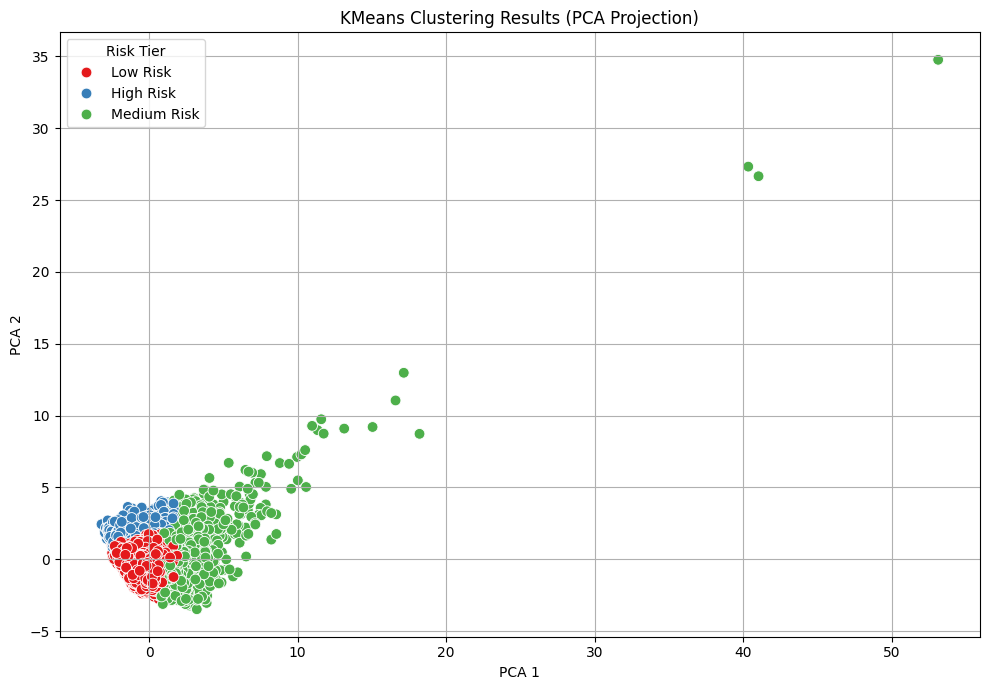

In [13]:
# 1. Load the Preprocessed data
df_formodel = pd.read_csv("cleaned_data.csv")

# Feature selection
categorical_cols = ['Home_Ownership', 'Loan_Purpose']
numeric_cols = ['Annual_Income', 'Loan_Amount', 'Credit_History_Length', 'Credit_Score', 'Previous_Loan_Defaults']

# One-hot encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_formodel[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=df_formodel.index)

# Standard scale numeric columns
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df_formodel[numeric_cols])
scaled_df = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=df_formodel.index)

# Combine processed features
df_processed = pd.concat([scaled_df, encoded_df], axis=1)
X_cluster = df_processed.values  # Matrix for clustering

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_formodel['cluster_id'] = kmeans.fit_predict(X_cluster)

# Dynamic cluster naming based on default rate
# Ensure Loan_Status is binary: 1 = Approved, 0 = Default
cluster_approval_rates = df_formodel.groupby('cluster_id')['Loan_Status'].mean()
sorted_clusters = cluster_approval_rates.sort_values()  # Lower approval = higher risk

# Map cluster_id → risk label dynamically
risk_labels = ['High Risk', 'Medium Risk', 'Low Risk']
cluster_to_label = dict(zip(sorted_clusters.index, risk_labels))

# Apply risk labels
df_formodel['credit_risk_label'] = df_formodel['cluster_id'].map(cluster_to_label)

# Cluster profile
cluster_profile = df_formodel.groupby('credit_risk_label')[numeric_cols + categorical_cols + ['Loan_Status']].agg(['mean', 'count'])
print("\n Table 1: Cluster Profile (Mean Stats + Counts):\n")
print(cluster_profile)

# Default rate per cluster
default_rate = df_formodel.groupby('credit_risk_label')['Loan_Status'].value_counts(normalize=True).unstack()
print("\n Table 2: Default Rate per Cluster:\n")
print(default_rate)

# Silhouette Score
score = silhouette_score(X_cluster, df_formodel['cluster_id'])
print(f"\nSilhouette Score (based on KMeans clusters): {score:.4f}")

# ========== TEST SET ==========

# Preprocess X_test using same encoder and scaler
# Make sure X_test is already defined elsewhere in your code
encoded_test = encoder.transform(X_test[categorical_cols])
scaled_test = scaler.transform(X_test[numeric_cols])
X_test_pca = np.column_stack([scaled_test, encoded_test])

# Predict clusters for test set
X_test_with_clusters = X_test.copy()
X_test_with_clusters['cluster_id'] = kmeans.predict(X_test_pca)
X_test_with_clusters['credit_risk_label'] = X_test_with_clusters['cluster_id'].map(cluster_to_label)

# ========== OPTIONAL: PCA Plot ==========
# Reduce to 2D using PCA (for visualization only)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

# Visualize KMeans clustering results using PCA-reduced 2D projection
plt.figure(figsize=(10, 7))  # Set the figure size for better readability

# Use a distinct color palette for each risk tier
palette = sns.color_palette("Set1", n_colors=3)

# Create a scatter plot of the PCA-reduced data, colored by cluster risk label
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df_formodel['credit_risk_label'], 
    palette=palette, 
    s=60
)

plt.title("KMeans Clustering Results (PCA Projection)")  # Add a descriptive title
plt.xlabel("PCA 1")  # Label for the first principal component
plt.ylabel("PCA 2")  # Label for the second principal component
plt.legend(title="Risk Tier")  # Add a legend with a title
plt.grid(True)  # Show gridlines for easier interpretation
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

CHECKING OUTLIERS

In [14]:
# Step 1: Predict numeric cluster labels again (to map correctly to centroids)
numeric_labels = kmeans.predict(X_cluster)

# Step 2: Get KMeans cluster centers (in the full X_cluster space)
centroids = kmeans.cluster_centers_

# Step 3: Compute distances from each point to its assigned cluster center
distances = np.linalg.norm(X_cluster - centroids[numeric_labels], axis=1)

# Step 4: Define outliers as those beyond the 95th percentile
threshold = np.percentile(distances, 95)
outlier_mask = distances > threshold
num_outliers = np.sum(outlier_mask)

print(f"\nNumber of Outliers (95th percentile distance): {num_outliers}")

# Optional: Tag the outliers in your DataFrame
df_formodel['Outlier'] = outlier_mask


Number of Outliers (95th percentile distance): 2250


CLUSTER QUALITY EVALUATION: COMPARING KMEANS CREDIT RISK SEGMENTS WITH TRUE LOAN OUTCOMES

In [15]:
# 1. Reverse map cluster names back to original numeric labels
reverse_cluster_names = {v: k for k, v in cluster_to_label.items()}
df_formodel['cluster_numeric'] = df_formodel['credit_risk_label'].map(reverse_cluster_names)

# 2. Encode the 'Loan_Status' column (Approved=1, Rejected=0)
le = LabelEncoder()
df_formodel['outcome_numeric'] = le.fit_transform(df_formodel['Loan_Status'])

# 3. Get arrays of true labels and predicted clusters
true_labels = df_formodel['outcome_numeric'].values
predicted_clusters = df_formodel['cluster_numeric'].values

# 4. Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# 5. Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(true_labels, predicted_clusters)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# 6. Homogeneity, Completeness, V-Measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, predicted_clusters)
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")

# 7. Cross-tabulation for intuitive comparison
print("\nCross-tabulation (Cluster vs Outcome):")
crosstab = pd.crosstab(df_formodel['credit_risk_label'], df_formodel['Loan_Status'], normalize='index')
print(crosstab)

Adjusted Rand Index (ARI): 0.1482
Normalized Mutual Information (NMI): 0.2146
Homogeneity: 0.3143
Completeness: 0.1630
V-Measure: 0.2146

Cross-tabulation (Cluster vs Outcome):
Loan_Status               0         1
credit_risk_label                    
High Risk          1.000000  0.000000
Low Risk           0.536314  0.463686
Medium Risk        0.792424  0.207576


SHAP EXPLAINER

In [16]:
# Create a SHAP explainer for trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [17]:
# Show full text in DataFrame columns for better readability in outputs
pd.set_option('display.max_colwidth', None)

num_applicants = 100  # Number of top applicants to explain
num_features = 5      # Number of top contributing features to show per applicant

explanations = []

# Helper function to convert feature values into human-readable strings
def readable_value(fname, val):
    if isinstance(val, (bool, np.bool_)):
        return "Yes" if val else "No"
    if fname.endswith("_Yes") or fname.endswith("_No"):
        return "Yes" if val == 1 else "No"
    if "_" in fname and (val == 1 or val == 0):
        base, cat = fname.rsplit("_", 1)
        if val == 1:
            return f"is {cat}"
        else:
            return f"is not {cat}"
    return val

# Loop through the top applicants in X_test to generate explanations
for i in range(min(num_applicants, X_test.shape[0])):
    shap_row = shap_values[i]  # SHAP values for this applicant
    feature_values = X_test.iloc[i]  # Feature values for this applicant
    prediction = xgb_model.predict(X_test.iloc[[i]])[0]  # Model prediction
    outcome = 'Approved' if prediction == 1 else 'Rejected'

    # Get indices of top features by absolute SHAP value
    top_idx = np.argsort(np.abs(shap_row))[::-1][:num_features]
    reasons = []
    tips = set()

    # Get cluster label and summary for this applicant
    cluster = X_test_with_clusters.iloc[i]['credit_risk_label']
    cluster_profile = ""
    cluster_summary = ""

    # Assign cluster profile and summary text
    if cluster == 'Low Risk':
        cluster_summary = "Applicants in this group typically have steady incomes, strong credit scores, and long credit histories. They show the lowest default rates and highest loan approval rates—representing the safest financial profile."
        cluster_profile = "Low Risk"
    elif cluster == 'High Risk':
        cluster_profile = "High Risk"
        cluster_summary = "This segment is characterized by moderate incomes, weaker credit scores, and shorter credit histories. They experience the highest default rates and lowest approval rates, indicating significant financial risk."
    elif cluster == 'Medium Risk':
        cluster_profile = "Medium Risk"
        cluster_summary = "These applicants generally have higher incomes and larger loan requests, with longer credit histories. However, their default rates are moderate, and approval rates are average—suggesting that while financially strong, they may still pose some risk."

    # Analyze top features and generate reasons and tips
    for idx in top_idx:
        fname = X_test.columns[idx]
        val = feature_values[fname]
        val_str = readable_value(fname, val)
        impact = shap_row[idx]

        # For approved loans, show only positive contributions
        if outcome == 'Approved' and impact > 0:
            reasons.append(f"<b>{fname}</b> contributed positively to loan approval.")
        # For rejected loans, show only negative contributions and give advice
        elif outcome == 'Rejected' and impact < 0:
            reasons.append(f"<b>{fname}</b> contributed negatively to loan approval.")
            # Tailored advice based on the feature
            if 'Income' in fname:
                tips.add("Consider increasing your annual income or adding a co-applicant to strengthen your application.")
            elif 'Credit_Score' in fname:
                tips.add("Work on improving your credit score by paying bills on time and reducing outstanding debts.")
            elif 'Loan_Amount' in fname:
                tips.add("Try applying for a lower loan amount or extending your repayment period.")
            elif 'Home_Ownership' in fname:
                tips.add("Having stable home ownership can improve eligibility. Provide additional documentation if possible.")
            elif 'Credit_History_Length' in fname:
                tips.add("A longer credit history is favorable. Keep your credit accounts open and active.")
            elif 'Previous_Loan_Defaults' in fname:
                tips.add("Avoid Loan defaults and maintain a clean repayment record to boost your chances.")
            elif 'Loan_Purpose' in fname:
                tips.add("Loan purpose is HighRisk.")
            else:
                tips.add(f"Review your {fname.replace('_', ' ')} for potential improvement.")

    # Get loan ID if available, otherwise create a default one
    loan_id = feature_values['Loan_ID'] if 'Loan_ID' in feature_values else f"Loan_{i+1}"
    # Combine advice tips or give a default message for approved loans
    advice_text = " ".join(tips) if outcome == 'Rejected' and tips else "No specific advice. Keep up the good financial habits."

    # Collect explanation for this applicant
    explanations.append({
        'Loan_Id': loan_id,
        'Outcome': outcome,
        'Reasons': " ".join(reasons) if reasons else "No major contributing factors found.",
        'Advice': advice_text,
        'Risk Profile': cluster_profile,
        'Risk Profile Summary': cluster_summary
    })

# Convert explanations to DataFrame for display
explanation_df = pd.DataFrame(explanations)

# Display the explanations as an HTML table with formatting
display(HTML(explanation_df.to_html(escape=False)))

,Loan_Id,Outcome,Reasons,Advice,Risk Profile,Risk Profile Summary
0,Loan_1,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Loan_Amount contributed negatively to loan approval. Credit_Score contributed negatively to loan approval. Loan_Purpose contributed negatively to loan approval.,Loan purpose is HighRisk. Avoid Loan defaults and maintain a clean repayment record to boost your chances. Try applying for a lower loan amount or extending your repayment period. Work on improving your credit score by paying bills on time and reducing outstanding debts.,High Risk,"This segment is characterized by moderate incomes, weaker credit scores, and shorter credit histories. They experience the highest default rates and lowest approval rates, indicating significant financial risk."
1,Loan_2,Approved,Annual_Income contributed positively to loan approval. Loan_Amount contributed positively to loan approval. Previous_Loan_Defaults contributed positively to loan approval. Credit_Score contributed positively to loan approval. Credit_History_Length contributed positively to loan approval.,No specific advice. Keep up the good financial habits.,Low Risk,"Applicants in this group typically have steady incomes, strong credit scores, and long credit histories. They show the lowest default rates and highest loan approval rates—representing the safest financial profile."
2,Loan_3,Rejected,Loan_Amount contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Home_Ownership contributed negatively to loan approval.,Consider increasing your annual income or adding a co-applicant to strengthen your application. Try applying for a lower loan amount or extending your repayment period. Having stable home ownership can improve eligibility. Provide additional documentation if possible.,Low Risk,"Applicants in this group typically have steady incomes, strong credit scores, and long credit histories. They show the lowest default rates and highest loan approval rates—representing the safest financial profile."
3,Loan_4,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Loan_Amount contributed negatively to loan approval. Annual_Income contributed negatively to loan approval.,Avoid Loan defaults and maintain a clean repayment record to boost your chances. Consider increasing your annual income or adding a co-applicant to strengthen your application. Try applying for a lower loan amount or extending your repayment period.,Medium Risk,"These applicants generally have higher incomes and larger loan requests, with longer credit histories. However, their default rates are moderate, and approval rates are average—suggesting that while financially strong, they may still pose some risk."
4,Loan_5,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Home_Ownership contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Credit_Score contributed negatively to loan approval.,Avoid Loan defaults and maintain a clean repayment record to boost your chances. Consider increasing your annual income or adding a co-applicant to strengthen your application. Having stable home ownership can improve eligibility. Provide additional documentation if possible. Work on improving your credit score by paying bills on time and reducing outstanding debts.,High Risk,"This segment is characterized by moderate incomes, weaker credit scores, and shorter credit histories. They experience the highest default rates and lowest approval rates, indicating significant financial risk."
5,Loan_6,Approved,Annual_Income contributed positively to loan approval. Previous_Loan_Defaults contributed positively to loan approval. Home_Ownership contributed positively to loan approval.,No specific advice. Keep up the good financial habits.,Low Risk,"Applicants in this group typically have steady incomes, strong credit scores, and long credit histories. They show the lowest defa

C:\Users\ivych\AppData\Local\Temp\ipykernel_14596\3006565902.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)


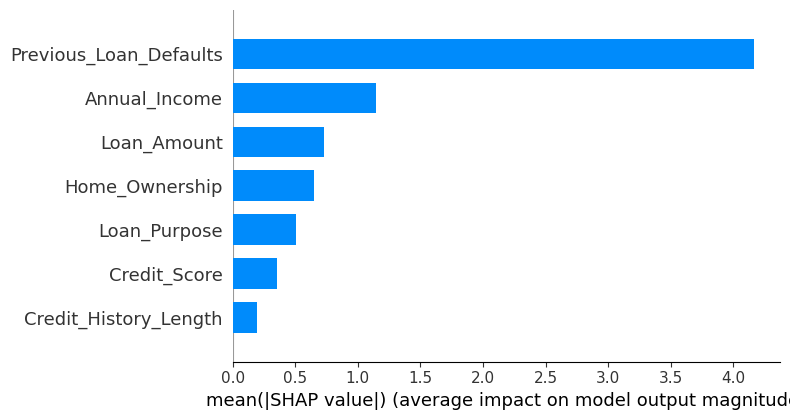

In [18]:
# Plot a SHAP summary bar plot showing the top 10 most important features for the XGBoost model's predictions on the test set
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

COMPARISON OF XGBOOST BEFORE VS AFTER HYPERPARAMETER OPTIMIZATION

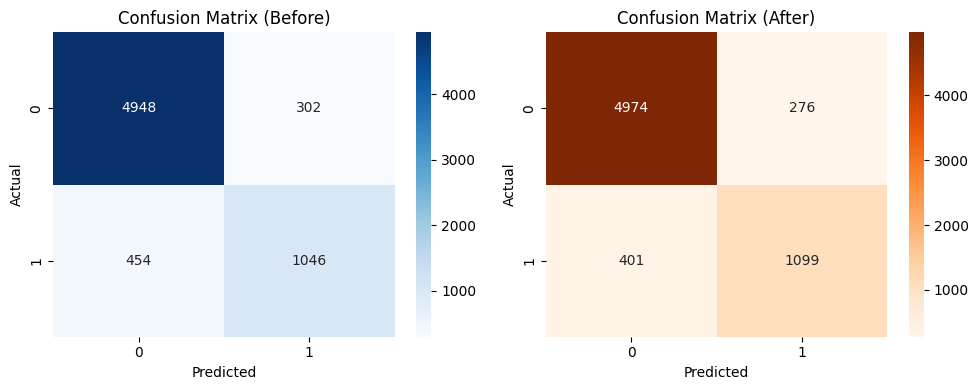

In [19]:
# 2. Confusion Matrices (Before and After XGBoost Hyperparameter Optimization)

# Create a figure with two subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot confusion matrix before optimization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Before)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot confusion matrix after optimization
sns.heatmap(conf_matrix_after, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Confusion Matrix (After)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()